## Using NLP to Analyse Data Science Articles in Medium to Uncover Topics and Predict Audience Engagement

##### By: David Bender for Springboard Course (May 2020 cohort) | email: [bender2242@gmail.com](mailto:bender2242@gmail.com)

###### This notebook is intended to help those who are interested in popular and emerging topics in data science, as well as provide some analysis that may be useful if you are thinking about writing your own data science blog posts or articles. Consider it a meta-analysis of data science topics and tactics, taken from authors who have published on the popular blogging site Medium. I will be using several approaches for natural language processing (NLP) including both supervised and unsupervised models to analyse the articles.


### STAGE 1: Import the dataset of Medium articles and explore the data

##### This data is available on Kaggle: [click here](https://www.kaggle.com/hsankesara/medium-articles)

>#### Step 1: Import the required packages and data
>#### Step 2: Using custom modules to clean and explore the data
>#### Step 3: Remove outliers
>#### Step 4: Process the data for text analysis
>#### Step 5: Check the language of the text, keeping only English articles
>#### Step 6: Extract organisations mentioned in the text, using spaCy's Natural Entity Recognition

---

## STAGE 2: Using NLP tools and approaches to analyse the text, including visualising the topics and phrases in the articles and predicting the number of claps that an article or title might receive from the Medium community.

#### Approach 1: scikit-learn prediction for number of claps, using the text of the articles

scikit-learn models:
- DummyRegressor (to baseline against random chance)
- CountVectorizer
- TfidfVectorizer

#### Approach 2: Analysing the text using word vectors, and predicting the number of claps 

Models/Packages:
- spacy: Entity Recognition
- spaCy: word vector's (pre-trained on Wikipedia corpus)
- keras: word2vec

#### Approach 3: Analysing the topics and entities in the articles using unsupervised topic modelling and clustering

Models/Packages:
- sklearn: TSNE
- sklearn: Latent Dirichlet Allocation
- pyLDAvis: interactive topic visualisation and analysis tool

#### Bonus: A 'clap predictor' for new titles, based on the best performing models from above

In [164]:
## Import the required packages. Also available to install via the requirements.txt file in the project folder

# Standard python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML and NLP packages
import sklearn
import spacy
#! python -m spacy download en_core_web_sm comment this first time importing
import en_core_web_sm
import nltk

# Text processing
import re
import string
#from bs4 import BeautifulSoup
#from collections import Counter 
#nltk.download('words') # Use for English language corpus
#nltk.download('punkt') # Download for sentence and word tokenization

# Machine learning tools
import sklearn
#import tensorflow as tf
#from tensorflow import keras

# Custom module
#%load_ext autoreload
%autoreload 2
%aimport article_analysis

#### Exploring the data

In [165]:
articles = pd.read_csv('../data/data.csv')
articles.head()

,author,claps,reading_time,link,title,text
0,Justin Lee,8.3K,11,https://medium.com/swlh/chatbots-were-the-next...,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T..."
1,Conor Dewey,1.4K,7,https://towardsdatascience.com/python-for-data...,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...
2,William Koehrsen,2.8K,11,https://towardsdatascience.com/automated-featu...,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...
3,Gant Laborde,1.3K,7,https://medium.freecodecamp.org/machine-learni...,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...
4,Emmanuel Ameisen,935,11,https://blog.insightdatascience.com/reinforcem...,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...


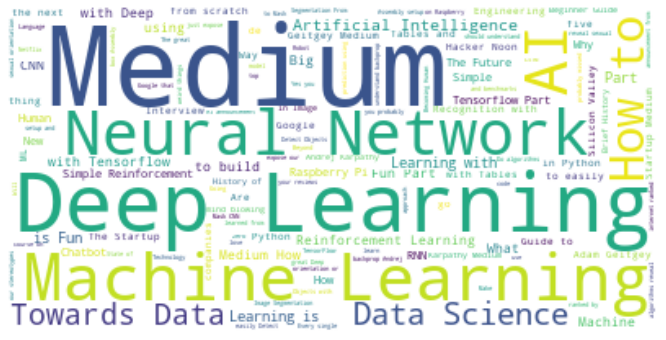

In [166]:
## We can import the custom module to run some data cleaning and analysis
from article_analysis.data import ArticleDataset

# We create the custom object ArticleDataset to run our data exploration and cleaning functions
analysis = ArticleDataset(articles)

# A wordcloud to understand the general topics in the text of the dataset
analysis.generate_wordcloud(articles.title)

In [167]:
## For this particular dataset, we need to perform some basic data cleaning on some of the columns

# Format claps from string into integer
claps_number = []
for clap in articles.claps:
    if 'K' in str(clap):
        clap_num = clap[:-1]
        clap_num = float(clap_num) * 1000
        claps_number.append(int(clap_num))
    else:
        claps_number.append(clap)
        
articles['claps'] = [int(x) for x in claps_number] # Convert the claps column into the formatted number
filtered_columns = ['author','claps','title','text'] # Select columns in dataframe
articles = articles[filtered_columns]
articles = articles.drop_duplicates().reset_index(drop=True) # some duplicate articles were in the dataset
articles.head()

,author,claps,title,text
0,Justin Lee,8300,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T..."
1,Conor Dewey,1400,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...
2,William Koehrsen,2800,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...
3,Gant Laborde,1300,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...
4,Emmanuel Ameisen,935,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...


#### Outlier values in the claps count will likely be an issue, so we will create a function to identify and visualise these examples

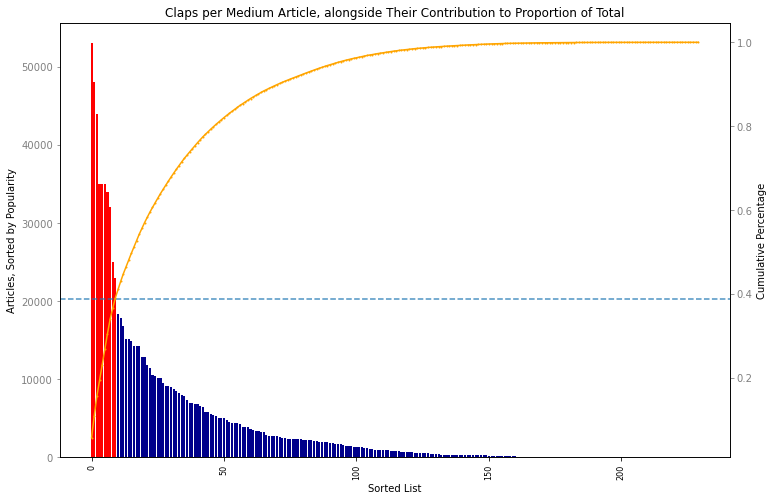

The articles to exclude are:

1 - How Does Spotify Know You So Well? – Member Feature Stories – Medium: 53000 claps.
2 - I interviewed at five top companies in Silicon Valley in five days, and luckily got five job offers: 48000 claps.
3 - Blockchain is not only crappy technology but a bad vision for the future: 44000 claps.
4 - The impossibility of intelligence explosion – François Chollet – Medium: 35000 claps.
5 - Software 2.0 – Andrej Karpathy – Medium: 35000 claps.
6 - Machine Learning is Fun! – Adam Geitgey – Medium: 35000 claps.
7 - Artificial Intelligence — The Revolution Hasn’t Happened Yet: 34000 claps.
8 - A Beginner’s Guide to AI/ML 🤖👶 – Machine Learning for Humans – Medium: 32000 claps.
9 - Artwork Personalization at Netflix – Netflix TechBlog – Medium: 25000 claps.
10 - Understanding Hinton’s Capsule Networks. Part I: Intuition.: 23000 claps.

The dataset now has 220 articles at this stage.


In [168]:
## We will apply one of our custom functions from the imported module to visualise the outliers
outliers = analysis.exclude_outliers(articles.claps, negatives=False, rounded=0)

# The 'outliers' variable will return four values for upper and lower bounds and specified n-values at top and bottom.
# We are interested exclusively in the upper values.
upper_claps = outliers[0]
lower_claps = outliers[1]
n_upper = outliers[2]

analysis.make_paretto_chart(dataframe=articles, 
                            column_name='claps', 
                            cutoff=upper_claps, 
                            n_top=n_upper,
                            title='Claps per Medium Article, alongside Their Contribution to Proportion of Total')


## Now we can filter the articles dataset by removing the outliers
articles = articles[(articles.claps < upper_claps) & (articles.claps > lower_claps)].reset_index(drop=True)
print('\nThe dataset now has {} articles at this stage.'.format(len(articles)))

#### Next, we will preprocess the text for analysis

##### We can do this by importing an object and its function that will allow us to specify which preprocessing steps we would like to perform

In [169]:
from article_analysis.data import TextProcessing

# This custom object has several text preprocessing steps that you can use, including identifying the language of the text
articles['preprocessed_text'] = [TextProcessing.preprocess_text(article, stop_words=True, lemmatize=False)[0] for article in articles.text ]
articles['language'] = [TextProcessing.preprocess_text(article, stop_words=True, lemmatize=False)[1] for article in articles.text ]

# We will also use spaCy's entity recognition function to extract all of the Organizations that are mentioned, 
# which we will use later when topic modelling and predicting popularity.
articles['organizations_mentioned'] = [TextProcessing.list_of_entities(article) for article in articles.text]

# Show a selection of the results
articles.head()

,author,claps,title,text,preprocessed_text,language,organizations_mentioned
0,Justin Lee,8300,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T...",oh headlines blared chatbots next big thing ho...,en,"[the Mobile World Congress 2017, Lyft, GrowthB..."
1,Conor Dewey,1400,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...,youve ever found looking question concept synt...,en,"[StackOverflow, Pandas, SQL, Merge, DataFrame,..."
2,William Koehrsen,2800,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...,machine learning increasingly moving handdesig...,en,"[TPOT, algorithm, Python, GitHub, Pandas, Pyth..."
3,Gant Laborde,1300,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...,understanding ai machine learning big question...,en,"[A.I., Brilliant.org, the Artificial Neural Ne..."
4,Emmanuel Ameisen,935,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...,want learn applied artificial intelligence lea...,en,"[Artificial Intelligence, the Insight Artifici..."


In [170]:
## Now let's take a look at the full dataset that we will be using, after processing steps, removing duplicates, and keeping only English articles
articles = articles[articles.language == 'en'].reset_index(drop=True)
articles

,author,claps,title,text,preprocessed_text,language,organizations_mentioned
0,Justin Lee,8300,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T...",oh headlines blared chatbots next big thing ho...,en,"[the Mobile World Congress 2017, Lyft, GrowthB..."
1,Conor Dewey,1400,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...,youve ever found looking question concept synt...,en,"[StackOverflow, Pandas, SQL, Merge, DataFrame,..."
2,William Koehrsen,2800,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...,machine learning increasingly moving handdesig...,en,"[TPOT, algorithm, Python, GitHub, Pandas, Pyth..."
3,Gant Laborde,1300,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...,understanding ai machine learning big question...,en,"[A.I., Brilliant.org, the Artificial Neural Ne..."
4,Emmanuel Ameisen,935,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...,want learn applied artificial intelligence lea...,en,"[Artificial Intelligence, the Insight Artifici..."
...,...,...,...,...,...,...,...
209,Max Pechyonkin,3400,Stochastic Weight Averaging — a New Way to Get...,"In this article, I will discuss two interestin...",article discuss two interesting recent papers ...,en,"[Kaggle, algorithm, SGD, FGE, SWA, PyTorch, Li..."
210,Eugenio Culurciello,2800,"Artificial Intelligence, AI in 2018 and beyond...",These are my opinions on where deep neural net...,opinions deep neural network machine learning ...,en,"[smart homes, the de-facto tool, Attention, FW..."
211,Devin Soni,5800,"Spiking Neural Networks, the Next Generation o...",Everyone who has been remotely tuned in to rec...,everyone remotely tuned recent progress machin...,en,"[CNN, IBM, TrueNorth]"
212,Carlos E. Perez,3900,Surprise! Neurons are Now More Complex than We...,One of the biggest misconceptions around is th...,one biggest misconceptions around idea deep le...,en,"[Artificial Neural Networks, ANN, IBM TrueNort..."


In [171]:
## You can also export this dataframe for use in the future, to save time
path = '../data/processed_data.csv'
articles.to_csv(path)

# And retrieve it here...
articles = pd.read_csv(path, index_col=0)

In [172]:
articles

,author,claps,title,text,preprocessed_text,language,organizations_mentioned
0,Justin Lee,8300,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T...",oh headlines blared chatbots next big thing ho...,en,"['the Mobile World Congress 2017', 'Lyft', 'Gr..."
1,Conor Dewey,1400,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...,youve ever found looking question concept synt...,en,"['StackOverflow', 'Pandas', 'SQL', 'Merge', 'D..."
2,William Koehrsen,2800,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...,machine learning increasingly moving handdesig...,en,"['TPOT', 'algorithm', 'Python', 'GitHub', 'Pan..."
3,Gant Laborde,1300,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...,understanding ai machine learning big question...,en,"['A.I.', 'Brilliant.org', 'the Artificial Neur..."
4,Emmanuel Ameisen,935,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...,want learn applied artificial intelligence lea...,en,"['Artificial Intelligence', 'the Insight Artif..."
...,...,...,...,...,...,...,...
209,Max Pechyonkin,3400,Stochastic Weight Averaging — a New Way to Get...,"In this article, I will discuss two interestin...",article discuss two interesting recent papers ...,en,"['Kaggle', 'algorithm', 'SGD', 'FGE', 'SWA', '..."
210,Eugenio Culurciello,2800,"Artificial Intelligence, AI in 2018 and beyond...",These are my opinions on where deep neural net...,opinions deep neural network machine learning ...,en,"['smart homes', 'the de-facto tool', 'Attentio..."
211,Devin Soni,5800,"Spiking Neural Networks, the Next Generation o...",Everyone who has been remotely tuned in to rec...,everyone remotely tuned recent progress machin...,en,"['CNN', 'IBM', 'TrueNorth']"
212,Carlos E. Perez,3900,Surprise! Neurons are Now More Complex than We...,One of the biggest misconceptions around is th...,one biggest misconceptions around idea deep le...,en,"['Artificial Neural Networks', 'ANN', 'IBM Tru..."


## STAGE 2:

#### Approach 1: scikit-learn prediction for number of claps, using the text of the articles

Models:
- DummyRegressor (to baseline against random chance)
- CountVectorizer
- TfidfVectorizer



#### Approach 4: Predicting number of claps based on article text or title

Models/Packages:
- sklearn: RandomForestRegressor

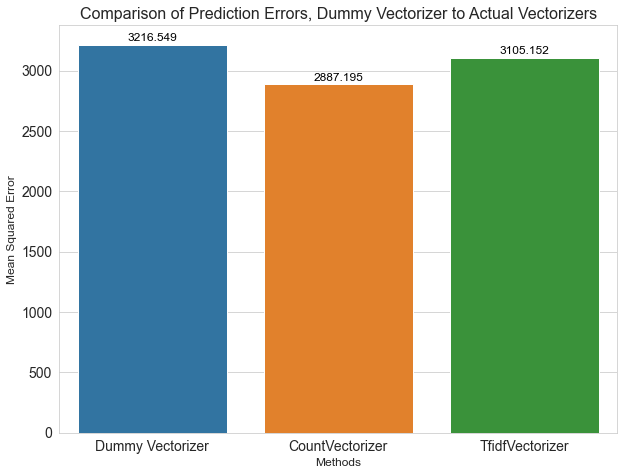

In [240]:
from article_analysis.models import ArticleModeller

# Instantiate the custom object
modeller = ArticleModeller(X=articles.text, y=articles.claps)

# Select Vectorizer
vectorizers = [CountVectorizer, TfidfVectorizer]
vectorizer_names = ['CountVectorizer', 'TfidfVectorizer']

# Select sci-kit learn model for prediction
model = RandomForestRegressor()

# Run the function that combines the dummy vectorizer with our specified vectorizers and visualise the results
x = modeller.run_dummy_and_vectorizers(vectorizers=vectorizers, model=model, vectorizer_names=vectorizer_names)

#### Approach 2: Analysing the text in context, including identifying entities mentioned in the articles and word analogies based on word vectors 

Models/Packages:
- spacy: Entity Recognition
- spaCy: word vector's (pre-trained on Wikipedia corpus)
- keras: word2vec

In [135]:
from sklearn.neighbors import KNeighborsRegressor

X = articles_vectors_df.article_vectors
y = articles.claps

X_train, X_test, y_train, y_test

n_neighbors = 10
knn = KNeighborsRegressor(n_neighbors=n_neighbors)



ValueError: setting an array element with a sequence.

141

#### Approach 3: Analysing the topics in the articles using unsupervised topic modelling

Models/Packages:
- sklearn: TSNE and Bokeh for visualisation
- sklearn: Latent Dirichlet Allocation
- pyLDAvis: interactive topic visualisation and analysis tool

In [260]:
from article_analysis.models import TopicModeller

vectors = TopicModeller(dataframe=articles)
vectors.generate_word_vectors('title')

Loading BokehJS ...

In [262]:
vectors.generate_lda_visualisation(articles.text)

Loading BokehJS ...

In [254]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Initialise a Count Vectorizer for the entire article text corpus

text_to_topics = articles.text

LDA_vect = CountVectorizer(stop_words='english') 

LDA_count_data = LDA_vect.fit_transform(text_to_topics)

# Create and fit the LDA model
number_topics = 4
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(LDA_count_data)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=4, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [26]:
# Helper function to visualise the topics and top words
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic {}:".format(str(topic_idx + 1)))
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
def topic_clouds(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        plt.subplots(1,1, sharex=True, figsize=(8,8))
        
        wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='grey')
        topic_wordlist = " ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        
        #topic_most_common = most_common_words(topic_wordlist)[:n_top_words]
        wordcloud.generate(topic_wordlist)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title('Topic {}'.format(str(topic_idx + 1)), loc='left', fontsize=16)
        plt.axis('off')

# Tweak the number of words for display
print_number_words = 15

# Print out the top
print_topics(lda, LDA_vect, print_number_words)


Topic 1:
learning data network neural deep time training like use using networks model way app tensorflow

Topic 2:
learning data network neural model training function use image machine using like layer networks output

Topic 3:
data like time ai people just new use information way ve want make know work

Topic 4:
ai like people machine new intelligence time human data learning technology just work google computer


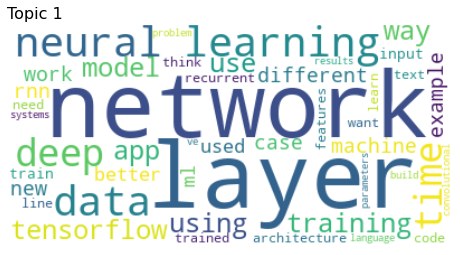

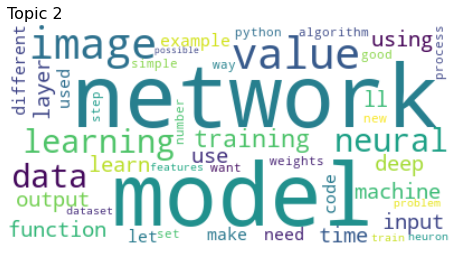

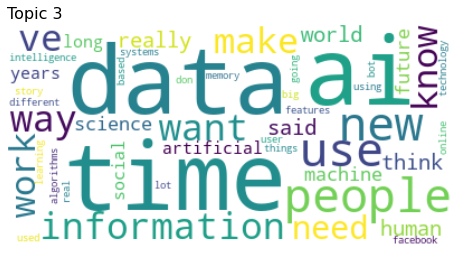

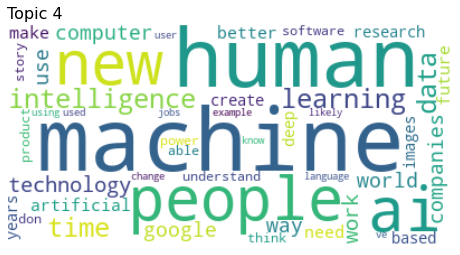

In [27]:
# Visualise the words in each topic as a word cloud for future labelling
cloud_number_words = 50

topic_clouds(lda, LDA_vect, cloud_number_words)

In [256]:
## Visualise with pyLDAvis
import pyLDAvis
from pyLDAvis import sklearn as sklearn_lda
from IPython.core.display import display, HTML
    
LDAvis_prepared = sklearn_lda.prepare(lda, LDA_count_data, LDA_vect)

path = './ldavis_prepared_'+ str(number_topics) +'.html'
    
pyLDAvis.save_html(LDAvis_prepared, path)

display(HTML(path))

##### Next, Entity Recognition

In [ ]:
from spacy import displacy

nlp = spacy.load("en_core_web_sm")
docs = [nlp(article) for article in articles.text ]

In [ ]:
word_vectors = [x.vector for x in doc for doc in docs]
word_vectors

In [ ]:
# Render the Entity Recognition within the text itself
    
displacy.render(docs[100], style="ent")

In [ ]:
entities_df = pd.DataFrame({'text':text, 'labels':labels})

for doc in docs:
    ents = [(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents]
    labels = [x[3] for x in ents ]
    text = [x[0] for x in ents ]
    list_ = set(zip(text, lables))
    labels_text[labels_text.labels == 'ORG'].drop_duplicates()

#### Approach 4: BERT for prediction

#### BONUS: Building a 'Clap Predictor' for article titles

In [ ]:
X = articles.title
y = articles.claps

vect = CountVectorizer(stop_words='english')

count_train = vect.fit_transform(X)

model = RandomForestRegressor()

model.fit(count_train, y)

title_input = input('What is your title? ')

title_input_transformed = vect.transform(nltk.wordpunct_tokenize(title_input))
#print(title_input_transformed)
#model.predict(title_input_transformed)
print('You should receive {:.0f} claps for that title!'.format(model.predict(title_input_transformed).mean()))

#### Steps in the analysis

1. Import the dataset
2. Clean it, keeping only English articles and words
3. Create a pipeline to remove stop words, count, lemmatize
4. Apply some NER from either spaCy or nltk to get topics
5. Create a pipeline to fit a corpus of  articles

    - Clean the data, removing stop words
    - Applying train_test_split
    - Fitting the model on training data
    - predicting on test data
    - outputting a MSE accuracy for regression
    - build n_gram for multi-word phrases
    - t-SNE for dimensionality reduction (after word embedding)
    
    
6. Pipeline for predicting on a specific article
7. Title predictor tool

#### Analysis to perform

- some basic exploratory analysis and charting
    - use Bokeh for this? Would be good package to get comfortable with
- Topic modeling with LDA
    - use pyLDAvis for cool topic explorer
- word2vec with gensim
- keras for prediction

#### Credit and Acknowledgments

 Ryan McCormack

 [A practitioner's guide to Natural Language Processing Part 1 - DJ Sarkar](https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72)
 
 [Word Cloud code](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)